In [9]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
import panel as pn
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets
from string import digits
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation


pn.extension()

%matplotlib inline

In [10]:
# Read the Mapbox API key
mapbox_token = os.getenv("MAPBOX_API_KEY")
load_dotenv()

True

In [11]:
# Read the ATLAS data into a Pandas DataFrame
file_path = Path("Resources/02_Anonymized/ATLAS.csv")
ATLAS = pd.read_csv(file_path, index_col="Customers")
ATLAS.head()

,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service
Customers,,,,,,
University 1,3/20/15,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16
University 2,5/28/15,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16
University 3,6/23/15,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16
University 4,6/26/15,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16
University 5,10/7/15,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16


In [12]:
# Cleanup/preprocessing

## Cean up dates column (TODO functionalize)
dates_of_service = ATLAS.iloc[0:6]["Dates of service "]

start_date_list = []
end_date_list = []

for date_of_service_str in dates_of_service:
    split1 = date_of_service_str.find("Subscription")
    split2 = split1 + len("Subscription")
    date_range = date_of_service_str[split2:].strip()

    split1 = date_range.find("to")
    split2 = split1 + len("to")
    if split1 < 0:
        split1 = date_range.find("-")
        split2 = split1 + len("-")
    date1_str = date_range[0:split1].strip()
    date2_str = date_range[split2:].strip()

    # TODO Catch and handle failed parsing.
    #print(f"date1_str: {date1_str}  date2_str: {date2_str}")
    date1 = pd.Timestamp(date1_str, tz="America/New_York")
    date2 = pd.Timestamp(date2_str, tz="America/New_York")
    #print(f"date1_str: {date1_str}  date1: {date1}")
    #print(f"date2_str: {date2_str}  date2: {date2}")

    start_date_list.append(date1)
    end_date_list.append(date2)

dates_df = pd.DataFrame({"Start date":start_date_list,"End date": end_date_list})
dates_df.head()
ATLAS_with_fixed_dates = pd.concat([ATLAS.reset_index(), dates_df], axis='columns', join="inner")
ATLAS_with_fixed_dates.head()

,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Start date,End date
0,University 1,3/20/15,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015-03-18 00:00:00-04:00,2016-06-30 00:00:00-04:00
1,University 2,5/28/15,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01 00:00:00-04:00,2016-06-30 00:00:00-04:00
2,University 3,6/23/15,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015-06-10 00:00:00-04:00,2016-06-30 00:00:00-04:00
3,University 4,6/26/15,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01 00:00:00-04:00,2016-06-30 00:00:00-04:00
4,University 5,10/7/15,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015-10-05 00:00:00-04:00,2016-09-30 00:00:00-04:00


In [13]:
# Adding New Columns to categorize data by Year, Month, and each Quarter
year_column = []
month_column = []
quarter_column = []
for date in ATLAS_with_fixed_dates["Start date"]:
    year_column.append(date.year)
    month_column.append(date.month)
    quarter_column.append(date.quarter)
    
# Add appended to the Data Frame (Start Date or Invoice Date)
periods_df = pd.DataFrame({"Year":year_column,"Monthly": month_column, "Quarterly": quarter_column})
periods_df.head()
ATLAS_with_periods = pd.concat([ATLAS.reset_index(), periods_df], axis='columns', join="inner")
ATLAS_with_periods.head()

,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Year,Monthly,Quarterly
0,University 1,3/20/15,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015,3,1
1,University 2,5/28/15,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015,6,2
2,University 3,6/23/15,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015,6,2
3,University 4,6/26/15,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015,6,2
4,University 5,10/7/15,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015,10,4


In [14]:
# Finding the types
ATLAS_with_periods.dtypes

Customers            object
Invoice Date         object
Invoice #            object
Invoice Amount       object
Subscription         object
Account Code         object
Dates of service     object
Year                  int64
Monthly               int64
Quarterly             int64
dtype: object

In [15]:
# Removing ($) Sign from the Invoice Amount
ATLAS_with_periods["Invoice Amount"] = ATLAS_with_periods["Invoice Amount"].str.replace('$','')
ATLAS_with_periods["Invoice Amount"] = ATLAS_with_periods["Invoice Amount"].str.replace(',', '').astype('float')
print(ATLAS_with_periods.dtypes)
ATLAS_with_periods.head()

Customers             object
Invoice Date          object
Invoice #             object
Invoice Amount       float64
Subscription          object
Account Code          object
Dates of service      object
Year                   int64
Monthly                int64
Quarterly              int64
dtype: object


,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Year,Monthly,Quarterly
0,University 1,3/20/15,ATLAS 315,72000.0,1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015,3,1
1,University 2,5/28/15,AJ501,3500.0,1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015,6,2
2,University 3,6/23/15,AJ502,3500.0,1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015,6,2
3,University 4,6/26/15,AJ503,6500.0,1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015,6,2
4,University 5,10/7/15,AJ504,750.0,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015,10,4


Text(0, 0.5, 'Yearly Invoice Amount')

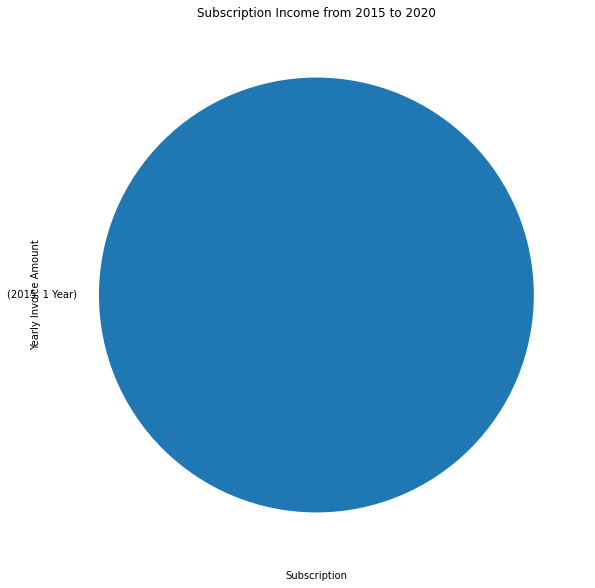

In [16]:
mean_subscription_income = ATLAS_with_periods.groupby(['Year', 'Subscription'])["Invoice Amount"].mean()
mean_subscription_income = mean_subscription_income.sort_index()
mean_subscription_income.plot.pie(title="Subscription Income from 2015 to 2020", figsize=(25,10))
plt.xlabel("Subscription")
plt.ylabel("Yearly Invoice Amount")

In [18]:
amount_min = ATLAS_with_periods.groupby(["Subscription"])["Invoice Amount"].min().min()
amount_max = ATLAS_with_periods.groupby(["Subscription"])["Invoice Amount"].max().max()
amount_std = ATLAS_with_periods["Invoice Amount"].std()

first_year = mean_subscription_income.index[0]
last_year = mean_subscription_income.index[-1]

fig_subscription_income = mean_subscription_income.plot.line(xlim=[first_year, last_year],
                                                figsize = (20, 10),
                                               ylim=[amount_min - amount_std, amount_max + amount_std])
fig_subscription_income.set_title("Yearly Income from 2015 to 2020")
fig_subscription_income.set_xlabel("Year")
fig_subscription_income.set_ylabel("Yearly Income")

plt.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
mean_yearly_income = ATLAS_with_periods.groupby(["Invoice Date"])["Invoice Amount"].mean()
mean_yearly_income = mean_yearly_income.sort_index()
mean_yearly_income.plot.pie(title="Yearly Income from 2015 to 2020", figsize=(25,10))
plt.xlabel("Yearly")
plt.ylabel("Yearly Invoice Amount")

In [ ]:
# # Use the Pandas plot function to plot the average Invoice Amount per Year.
# Note: You will need to manually adjust the y limit of the chart using the min and max values from above.
amount_min = ATLAS_with_periods.groupby(["Invoice Date"])["Invoice Amount"].min().min()
amount_max = ATLAS_with_periods.groupby(["Invoice Date"])["Invoice Amount"].max().max()
amount_std = ATLAS_with_periods["Invoice Amount"].std()

first_year = mean_yearly_income.index[0]
last_year = mean_yearly_income.index[-1]

fig_yearly_income = mean_yearly_income.plot.bar(xlim=[first_year, last_year],
                                                figsize = (20, 10),
                                               ylim=[amount_min - amount_std, amount_max + amount_std])
fig_yearly_income.set_title("Yearly Income from 2015 to 2020")
fig_yearly_income.set_xlabel("Year")
fig_yearly_income.set_ylabel("Yearly Income")

plt.show()

In [ ]:
# Change date format/type
ATLAS["Invoice Date"] = ATLAS["Invoice Amount"].str.replace('$','')

invoice_date = ATLAS.iloc[0:6]["Dates of service "]

date1 = pd.Timestamp(date1_str, tz="America/New_York").isoformat()


In [109]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [111]:
# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes between now and 3 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = [""]

# Get 3 year's worth of historical price data for Microsoft and Coca-Cola
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_ticker.head()

Empty DataFrame
Columns: [(APPL, open), (APPL, high), (APPL, low), (APPL, close), (APPL, volume)]
Index: []

In [5]:
# Read the ATLAS data into a Pandas DataFrame
file_path_1 = Path("Resources/02_Deanonymized/2021 forecast CSV.csv")
forecast = pd.read_csv(file_path_1, index_col="Organization Name")
forecast.head()

,Mailing State/Province,Organization Record Type,ATLAS Customer Type,Subscription Fee,Subscription Type,Contract Start Date,Contract End Date
Organization Name,,,,,,,
University 1,AL,College/University,System Wide IHE,62.6,3-Month,4/1/2020,6/30/2020
University 2,GA,College/University,Teacher Prep Program,250,3-Month,3/24/2020,6/30/2020
University 3,GU,College/University,NaN,250,3-Month,3/25/2020,6/30/2020
University 4,Hawaii,College/University,Teacher Prep Program,425,3-Month,3/25/2020,6/30/2020
University 5,North Dakota,General Organization,NaN,425,3-Month,4/9/2020,6/30/2020


In [4]:
file_path_2 = Path("Resources/02_Deanonymized/Revenue2020.csv")
revenue = pd.read_csv(file_path_2, index_col="Month")
revenue.head()

,Name,Total
Month,,
Jan,AL A&M Univ College,1820.00
Jan,Albertus Magnus College,1890.00
Jan,American College of Ed,883.33
Jan,Bainbridge Island,1200.00
Jan,CERRA SCNBN,1166.67


In [6]:
file_path_3 = Path("Resources/02_Deanonymized/Revenue2020A.csv")
payment = pd.read_csv(file_path_3, index_col="Payee Name")
payment.head()

ValueError: Index Payee Name invalid